In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Dataset

In [3]:
df = pd.read_csv('Cleaned_Anime.csv', index_col = 0)
df['Release_year'] = pd.to_datetime(df['Release_year'] )
df.info()
print(df[df['Tags'].str.contains(']', na = False)])


<class 'pandas.core.frame.DataFrame'>
Index: 13254 entries, 0 to 15488
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Name          13254 non-null  object        
 1   Rank          13254 non-null  float64       
 2   Rating        13254 non-null  float64       
 3   Release_year  13254 non-null  datetime64[ns]
 4   Episodes      13254 non-null  float64       
 5   Type          13254 non-null  object        
 6   Studio        13254 non-null  object        
 7   Tags          13254 non-null  object        
 8   staff         13254 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 1.0+ MB
Empty DataFrame
Columns: [Name, Rank, Rating, Release_year, Episodes, Type, Studio, Tags, staff]
Index: []


# Normalize the Studio Names

In [13]:
#Adjust the case sensitive of the Studio column
Studio_Normalize = df.loc[:]

#Normalize Studio
Studio_Normalize['Studio'] = Studio_Normalize['Studio'].str.lower()
Studio_Normalize['Studio'] = Studio_Normalize['Studio'].str.capitalize()


# Find interesting Genres

In [6]:
only_tags = df[df['Type']!= 'Movie'].loc[:,['Name','Tags','Studio']]
only_tags.dropna(inplace = True)

#Identify Genres. Comment out when not needed
with pd.option_context('display.max_colwidth', None):
    print(only_tags[only_tags['Name'].str.contains('Overlord', case = False)])

    
Interested_Genres = ['Action', 'Adventure', 'Comedy', 'Drama',\
'Fantasy','Shounen','Martial Arts', 'Violence','Superpowers',\
                     'Overpowered Main Characters','Isekai','Sexual Content','Magic']

only_tags[Interested_Genres] = 0
only_tags[Interested_Genres] = only_tags[Interested_Genres].astype(float)

                                                     Name  \
8584                                             Overlord   
8585  Overlord 6: Drama CD-tsuki Tokusou-ban - Yokoku-hen   
8586                                          Overlord II   
8587                      Overlord II: Play Play Pleiades   
8588                                         Overlord III   
8589                     Overlord III: Play Play Pleiades   
8590                                        Overlord Mask   
8591                         Overlord Movie: Manner Movie   
8592                         Overlord: Play Play Pleiades   
8593                     Overlord: Play Play Pleiades OVA   
8594   Overlord: Ple Ple Pleiades - Clementine Toubou-hen   
8595        Overlord: Ple Ple Pleiades Theatrical Version   

                                                                                                                                                                                                              

# Create algorithm to set Genres weights

In [7]:
#Algorithm to retrieve shows that has the interested Genres
for name, genres in zip(only_tags.index,only_tags['Tags']):
    tags = genres.split(',')

    
    for genre in tags:
        genre = genre.strip()
        #Add weights(Importance)to the genre
        if genre in ['Action', 'Adventure','Comedy','Isekai','Violence','Sexual Content']:
            only_tags.loc[name,genre] = 1
        elif genre in ['Fantasy','Shounen', 'Drama']:
            only_tags.loc[name,genre] = .5
        elif genre in ['Overpowered Main Characters','Superpowers','Martial Arts','Magic']:
            only_tags.loc[name,genre] = 2
      
          
            
only_tags['Total'] = only_tags.iloc[:,3:].sum(axis=1)
Six_or_More_Genres = only_tags[only_tags['Total'] > 5].sort_values('Total', ascending = False)   

# Retrieve the studios who has the most animes with interesting Genres

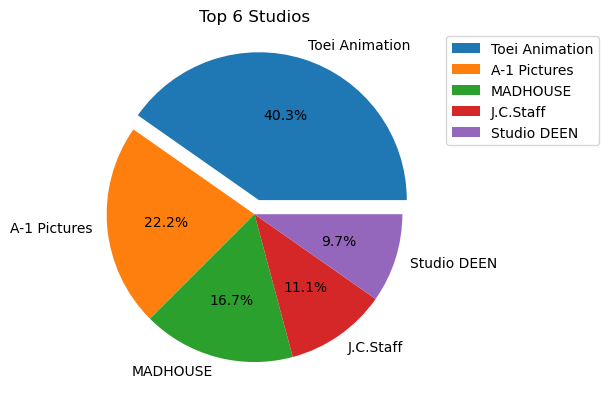

<Figure size 640x480 with 0 Axes>

In [8]:
studio_six_plus = Six_or_More_Genres.groupby('Studio').\
agg({'Studio':'size', 'Total':'sum'}).sort_values('Total',ascending = False)
studio_six_plus


#Determine the index of the maximum value
max_index = studio_six_plus['Studio'].idxmax()
# Create an explode list
explode = [0.1 if index == max_index else 0 for index in studio_six_plus.iloc[:5,0].index]

studio_six_plus.iloc[:5,0].plot(kind = 'pie', autopct = '%1.1f%%', explode= explode,
                                ylabel= '',labels = studio_six_plus.index)
plt.title('Top 6 Studios')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
plt.clf()

# Top three animes from the top three studio

In [9]:
#Retrieve top three studios Names and data
Top_Three_Studios = Studio_Normalize[(Studio_Normalize['Type']!= 'Movie') & (Studio_Normalize['Studio'].\
                                     isin(studio_six_plus.index[:3].str.lower().str.capitalize()))]

Top_Three_Shows = Top_Three_Studios[['Name','Rank','Studio']].\
sort_values('Rank').reset_index(drop = True).groupby('Studio').head(3)
Top_Three_Shows

,Name,Rank,Studio
0,Hunter x Hunter (2011),14.0,Madhouse
1,One-Punch Man,47.0,Madhouse
2,Hajime no Ippo: The Fighting!,64.0,Madhouse
4,Kaguya-sama: Love Is War?,74.0,A-1 pictures
5,ERASED,96.0,A-1 pictures
7,Your lie in April,114.0,A-1 pictures
9,One Piece,129.0,Toei animation
28,World Trigger 3rd Season,268.0,Toei animation
35,One Piece: Episode of Merry - Mou Hitori no Na...,325.0,Toei animation


# Graphical Representation

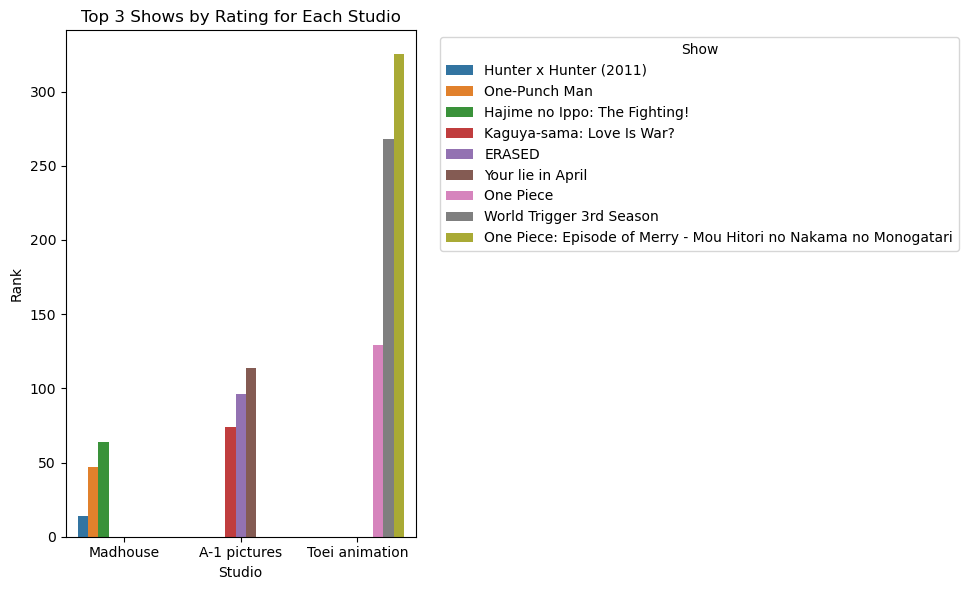

In [10]:
# Create the grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Studio', y='Rank', hue='Name', data=Top_Three_Shows, dodge=True)

# Add titles and labels
plt.title('Top 3 Shows by Rating for Each Studio')
plt.xlabel('Studio')
plt.ylabel('Rank')
plt.legend(title='Show', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()